# EENet and Deep Explain demo

Imports

In [1]:
import mne
import numpy as np
from mne import io
from mne.datasets import sample

import eegnet

# import tensorflow and disable eager execution right up front
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

from tensorflow.keras import utils as np_utils
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow.compat.v1.keras.backend as K
from tensorflow.keras.models import Model

from deepexplain.tf.v2_x import DeepExplain

Using tf version = 2.15.0
Using tf version = 2.15.0


## Read data

In [2]:
##################### Process, filter and epoch the data ######################
data_path = sample.data_path()

# Set parameters and read data
raw_fname = str(data_path) + '/MEG/sample/sample_audvis_filt-0-40_raw.fif'
event_fname = str(data_path) + '/MEG/sample/sample_audvis_filt-0-40_raw-eve.fif'
tmin, tmax = -0., 1
event_id = dict(aud_l=1, aud_r=2, vis_l=3, vis_r=4)

# Setup for reading the raw data
raw = io.Raw(raw_fname, preload=True, verbose=False)
raw.filter(2, None, method='iir')  # replace baselining with high-pass
events = mne.read_events(event_fname)

raw.info['bads'] = ['MEG 2443']  # set bad channels
picks = mne.pick_types(raw.info, meg=False, eeg=True, stim=False, eog=False,
                       exclude='bads')

# Read epochs
epochs = mne.Epochs(raw, events, event_id, tmin, tmax, proj=False,
                    picks=picks, baseline=None, preload=True, verbose=False)
labels = epochs.events[:, -1]

# extract raw data. scale by 1000 due to scaling sensitivity in deep learning
X = epochs.get_data()*1000 # format is in (trials, channels, samples)
y = labels

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 2 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoff at 2.00 Hz: -6.02 dB



### Prepare data for fitting

In [14]:
# take 50/25/25 percent of the data to train/validate/test
X_train      = X[0:144,]
Y_train      = y[0:144]
X_validate   = X[144:216,]
Y_validate   = y[144:216]
X_test       = X[216:,]
Y_test       = y[216:]

# convert labels to one-hot encodings.
Y_train      = np_utils.to_categorical(Y_train-1)
Y_validate   = np_utils.to_categorical(Y_validate-1)
Y_test       = np_utils.to_categorical(Y_test-1)

# convert data to NHWC (trials, channels, samples, kernels) format. Data 
# contains 60 channels and 151 time-points. Set the number of kernels to 1.
kernels, chans, samples = 1, 60, 151

X_train      = X_train.reshape(X_train.shape[0], chans, samples, kernels)
X_validate   = X_validate.reshape(X_validate.shape[0], chans, samples, kernels)
X_test       = X_test.reshape(X_test.shape[0], chans, samples, kernels)
   
print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

X_train shape: (144, 60, 151, 1)
144 train samples
72 test samples


## Fit EEGNet model

In [16]:
# while the default tensorflow ordering is 'channels_last' we set it here
# to be explicit in case if the user has changed the default ordering
K.set_image_data_format('channels_last')

# configure the EEGNet-8,2,16 model with kernel length of 32 samples (other 
# model configurations may do better, but this is a good starting point)
############################################################################
######## Remember to create and compile model only once in a session #######
############################################################################
model = eegnet.EEGNet(nb_classes = 4, Chans = chans, Samples = samples, 
               dropoutRate = 0.5, kernLength = 32, F1 = 8, D = 2, F2 = 16, 
               dropoutType = 'Dropout')

# compile the model and set the optimizers
model.compile(loss='categorical_crossentropy', optimizer='adam', 
              metrics = ['accuracy'])

# count number of parameters in the model
numParams    = model.count_params()    

# set a valid path for your system to record model checkpoints
checkpointer = ModelCheckpoint(filepath='/tmp/checkpoint.h5', verbose=1,
                               save_best_only=True)

###############################################################################
# if the classification task was imbalanced (significantly more trials in one
# class versus the others) you can assign a weight to each class during 
# optimization to balance it out. This data is approximately balanced so we 
# don't need to do this, but is shown here for illustration/completeness. 
###############################################################################

# the syntax is {class_1:weight_1, class_2:weight_2,...}. Here just setting
# the weights all to be 1
class_weights = {0:1, 1:1, 2:1, 3:1}

Instructions for updating:
Colocations handled automatically by placer.


In [17]:
fittedModel = model.fit(X_train, Y_train, batch_size = 16, epochs = 5, 
                        verbose = 2, validation_data=(X_validate, Y_validate),
                        callbacks=[checkpointer], class_weight = class_weights)

Train on 144 samples, validate on 72 samples
Epoch 1/5


2025-03-31 12:48:58.848267: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization pass is not enabled
2025-03-31 12:48:58.919784: W tensorflow/c/c_api.cc:305] Operation '{name:'training/Adam/batch_normalization_2/beta/v/Assign' id:649 op device:{requested: '', assigned: ''} def:{{{node training/Adam/batch_normalization_2/beta/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training/Adam/batch_normalization_2/beta/v, training/Adam/batch_normalization_2/beta/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.



Epoch 1: val_loss improved from inf to 1.38639, saving model to /tmp/checkpoint.h5
144/144 - 0s - loss: 1.3893 - accuracy: 0.2847 - val_loss: 1.3864 - val_accuracy: 0.2361 - 358ms/epoch - 2ms/sample
Epoch 2/5


/Users/anuszka/Projects/stopNet/venv/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
/Users/anuszka/Projects/stopNet/venv/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: val_loss improved from 1.38639 to 1.38638, saving model to /tmp/checkpoint.h5
144/144 - 0s - loss: 1.3849 - accuracy: 0.2708 - val_loss: 1.3864 - val_accuracy: 0.2361 - 156ms/epoch - 1ms/sample
Epoch 3/5

Epoch 3: val_loss did not improve from 1.38638
144/144 - 0s - loss: 1.3788 - accuracy: 0.2569 - val_loss: 1.3864 - val_accuracy: 0.2361 - 150ms/epoch - 1ms/sample
Epoch 4/5

Epoch 4: val_loss did not improve from 1.38638
144/144 - 0s - loss: 1.3508 - accuracy: 0.4306 - val_loss: 1.3864 - val_accuracy: 0.2361 - 158ms/epoch - 1ms/sample
Epoch 5/5

Epoch 5: val_loss did not improve from 1.38638
144/144 - 0s - loss: 1.3655 - accuracy: 0.3542 - val_loss: 1.3865 - val_accuracy: 0.2361 - 147ms/epoch - 1ms/sample


## Explain the model

In [7]:
with DeepExplain(session = K.get_session()) as de:
	input_tensor   = model.layers[0].input
	fModel         = Model(inputs = input_tensor, outputs = model.layers[-2].output)    
	target_tensor  = fModel(input_tensor)    

	# can use epsilon-LRP as well if you like.
	attributions   = de.explain('deeplift', target_tensor * Y_test, input_tensor, X_test)
	# attributions = de.explain('elrp', target_tensor * Y_test, input_tensor, X_test)

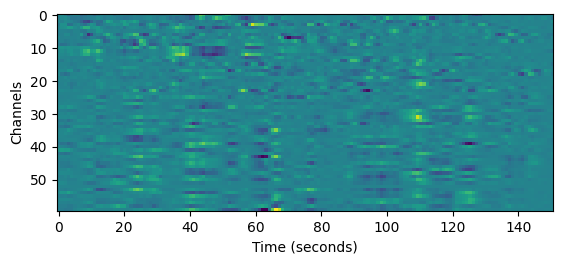

In [8]:
import matplotlib.pyplot as plt

plt.imshow(attributions[0, :, :].squeeze())
plt.xlabel('Time (seconds)')
plt.ylabel('Channels')
plt.show()
